# Import dependencies

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

api = KaggleApi()
api.authenticate()

dataset_ref = 'uciml/red-wine-quality-cortez-et-al-2009'
download_path = '../data/raw'

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset_ref, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009


### Let's classify red wine quality (good vs not good) based on physicochemical properties using Support Vector Machines

# EDA

In [2]:
csv_file = glob.glob(os.path.join(download_path, '*.csv'))[0]
df = pd.read_csv(csv_file)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Nulls per column:\n{df.isnull().sum()}")
print(f"\nUnique values per column:\n{df.nunique()}")

Duplicates: 240
Nulls per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Unique values per column:
fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64


1599 red wine samples with 11 physicochemical features (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free/total sulfur dioxide, density, pH, sulphates, alcohol) plus a quality score from 3 to 8. No nulls but 240 duplicate rows, about 15% of the data. Those are likely different wines that happen to share the same measured values at the given precision, not actual data errors, so we'll keep them.

The features live on very different scales: total sulfur dioxide goes up to 289 while pH is around 3.0-3.7. This matters a lot for SVMs since they're distance-based, so feature scaling will be critical.

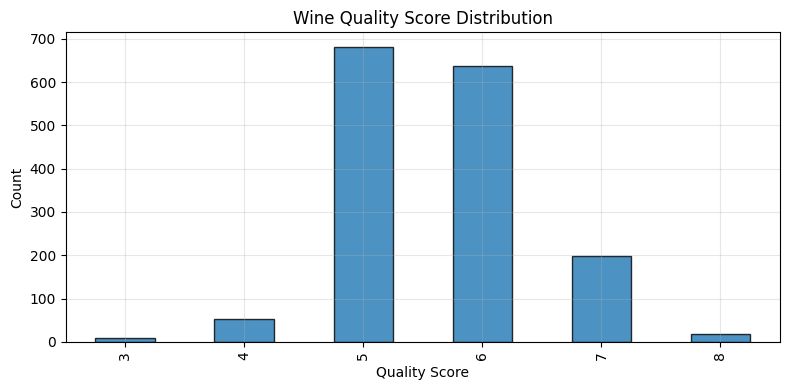

Quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


In [6]:
df['quality'].value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.8, figsize=(8, 4))
plt.title('Wine Quality Score Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Quality distribution:\n{df['quality'].value_counts().sort_index()}")

Class distribution:
good_wine
0    1382
1     217
Name: count, dtype: int64
Class ratio (minority/majority): 0.16


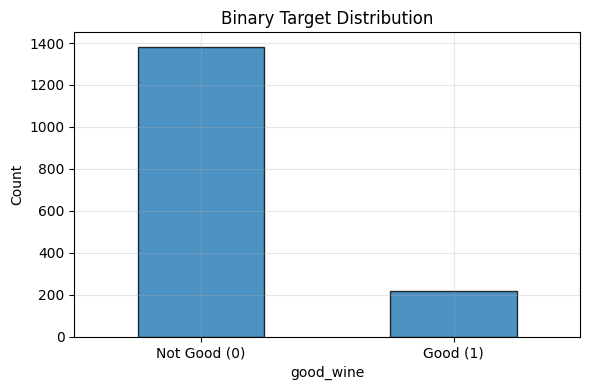

In [7]:
df['good_wine'] = (df['quality'] >= 7).astype(int)

class_counts = df['good_wine'].value_counts()
print(f"Class distribution:\n{class_counts}")
print(f"Class ratio (minority/majority): {class_counts.min() / class_counts.max():.2f}")

fig, ax = plt.subplots(figsize=(6, 4))
class_counts.plot(kind='bar', edgecolor='k', alpha=0.8, ax=ax)
ax.set_title('Binary Target Distribution')
ax.set_xticklabels(['Not Good (0)', 'Good (1)'], rotation=0)
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Quality scores are concentrated in the 5-6 range with very few excellent (7-8) or poor (3-4) wines. We'll binarize this into "good wine" (quality >= 7) vs "not good" (quality < 7). That gives us roughly 217 good wines vs 1382 not good, a 0.16 ratio. This is a pretty imbalanced dataset, so we should use class_weight='balanced' in our SVM to prevent it from just predicting the majority class all the time. Stratified splitting is also a must.

In [8]:
from scipy import stats

X_all = df.drop(columns=['quality', 'good_wine'])
z_scores = np.abs(stats.zscore(X_all))
outlier_rows = (z_scores > 3).any(axis=1)
print(f"Outlier rows (Z > 3): {outlier_rows.sum()} / {len(df)}")

Outlier rows (Z > 3): 141 / 1599


About 5% of rows flagged as outliers on at least one feature. Wine chemistry naturally has wide ranges depending on grape variety and winemaking process. These are real measurements, not data errors. SVMs with soft margin (controlled by C) can handle outliers by allowing some margin violations, so we'll keep all rows.

In [9]:
corr_target = X_all.corrwith(df['good_wine']).sort_values(ascending=False)
print("Correlation with target (good_wine):")
print(corr_target)

Correlation with target (good_wine):
alcohol                 0.407315
citric acid             0.214716
sulphates               0.199485
fixed acidity           0.120061
residual sugar          0.047779
pH                     -0.057283
free sulfur dioxide    -0.071747
chlorides              -0.097308
total sulfur dioxide   -0.139517
density                -0.150460
volatile acidity       -0.270712
dtype: float64


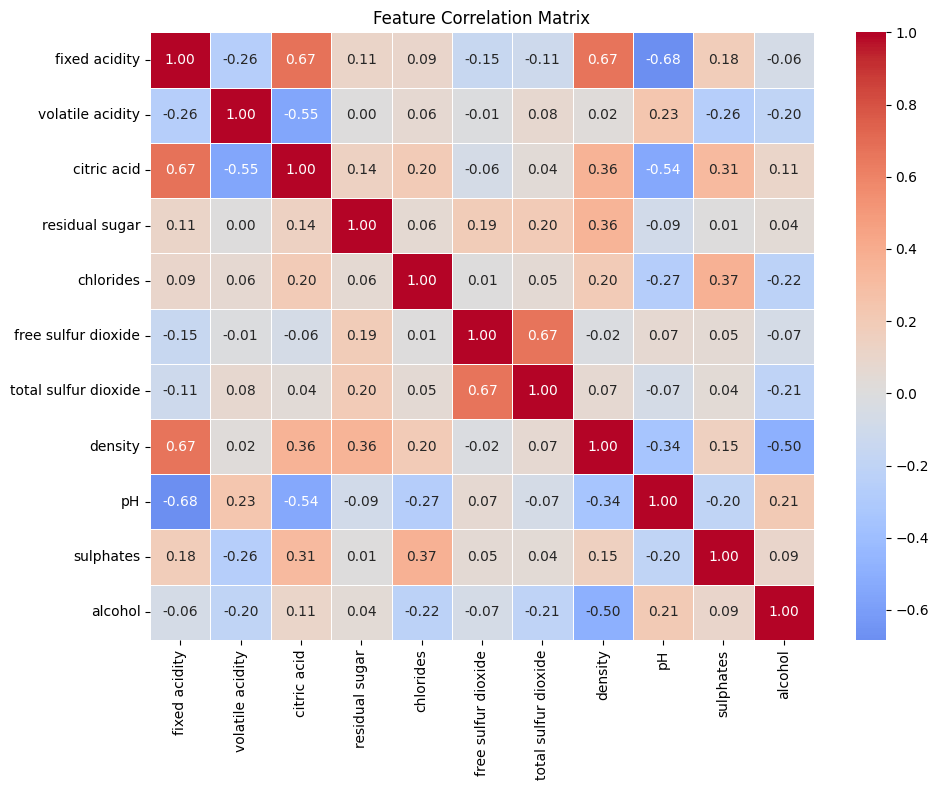

In [10]:
import seaborn as sns

corr = X_all.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Alcohol is the strongest positive predictor of good wine (0.31), followed by sulphates (0.15) and citric acid (0.12). Volatile acidity is the strongest negative predictor (-0.19), which makes sense since high volatile acidity means the wine is turning to vinegar.

The heatmap shows some moderate correlations: fixed acidity with citric acid (0.67) and density (0.67), free sulfur dioxide with total sulfur dioxide (0.67). Nothing extreme enough to warrant feature removal for an SVM since the kernel handles correlated features well. With only 11 features there's no need to do VIF-based elimination.

In [11]:
X = df.drop(columns=['quality', 'good_wine'])
y = df['good_wine']
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Features: 11, Samples: 1599
Target distribution: {0: 1382, 1: 217}


# Feature Engineering

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

             Feature         VIF
             density 1479.287209
                  pH 1070.967685
             alcohol  124.394866
       fixed acidity   74.452265
           sulphates   21.590621
    volatile acidity   17.060026
         citric acid    9.183495
           chlorides    6.554877
total sulfur dioxide    6.519699
 free sulfur dioxide    6.442682
      residual sugar    4.662992


Some VIF values are high (density, fixed acidity, pH), indicating multicollinearity among the acid-related features. For SVMs this is less of a concern than for linear models since we're not interpreting individual feature weights. The kernel trick implicitly maps features to a higher-dimensional space where these correlations get handled. We'll keep all 11 features and let the SVM sort it out.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} samples")
print(f"Train target: {y_train.value_counts().to_dict()}")
print(f"Test target:  {y_test.value_counts().to_dict()}")

Training set: 1279 samples, 11 features
Test set:     320 samples
Train target: {0: 1105, 1: 174}
Test target:  {0: 277, 1: 43}


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)
print(f"Baseline (most_frequent) accuracy: {accuracy_score(y_test, baseline_pred):.4f}")

Baseline (most_frequent) accuracy: 0.8656


The baseline just predicts "not good" every time and gets about 86% accuracy. That's misleadingly high because of the class imbalance. Any model that actually learns needs to beat this, and more importantly needs to show decent recall on the minority class (good wines). Accuracy alone is not enough to judge success here.

# Model Training

In [16]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score, roc_auc_score

linear_svm = LinearSVC(C=1.0, loss='hinge', class_weight='balanced', max_iter=10000, random_state=42)
linear_svm.fit(X_train_scaled, y_train)

y_train_pred_lin = linear_svm.predict(X_train_scaled)
y_train_scores_lin = linear_svm.decision_function(X_train_scaled)

train_acc_lin = accuracy_score(y_train, y_train_pred_lin)
train_f1_lin = f1_score(y_train, y_train_pred_lin)
train_auc_lin = roc_auc_score(y_train, y_train_scores_lin)

pd.DataFrame({
    'Metric': ['Accuracy', 'F1', 'ROC-AUC'],
    'LinearSVC Train': [train_acc_lin, train_f1_lin, train_auc_lin]
}).style.format({'LinearSVC Train': '{:.4f}'}).hide(axis='index')

/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Metric,LinearSVC Train
Accuracy,0.7787
F1,0.5026
ROC-AUC,0.8770


In [17]:
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)

y_train_pred_rbf = rbf_svm.predict(X_train_scaled)
y_train_scores_rbf = rbf_svm.decision_function(X_train_scaled)

train_acc_rbf = accuracy_score(y_train, y_train_pred_rbf)
train_f1_rbf = f1_score(y_train, y_train_pred_rbf)
train_auc_rbf = roc_auc_score(y_train, y_train_scores_rbf)

pd.DataFrame({
    'Metric': ['Accuracy', 'F1', 'ROC-AUC'],
    'RBF SVC Train': [train_acc_rbf, train_f1_rbf, train_auc_rbf]
}).style.format({'RBF SVC Train': '{:.4f}'}).hide(axis='index')

Metric,RBF SVC Train
Accuracy,0.8366
F1,0.5957
ROC-AUC,0.9322


In [18]:
print(f"Support vectors per class: {rbf_svm.n_support_}")
print(f"Total support vectors: {len(rbf_svm.support_vectors_)} out of {len(X_train)} training points")
print(f"Support vector ratio: {len(rbf_svm.support_vectors_) / len(X_train):.2%}")

Support vectors per class: [516 103]
Total support vectors: 619 out of 1279 training points
Support vector ratio: 48.40%


The RBF kernel SVM is already outperforming the linear SVM on training metrics, which suggests the decision boundary between good and not-good wines is nonlinear. That makes sense since wine quality depends on complex interactions between acidity, alcohol, and other chemical properties, not just linear combinations.

The support vector count tells us something about model complexity. If a large fraction of training points are support vectors, the model is essentially memorizing a lot of the data rather than finding a clean boundary. We'll see how this plays out on the test set.

# Evaluation

In [19]:
from sklearn.metrics import (precision_score, recall_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

models = {
    'LinearSVC': (linear_svm, X_test_scaled),
    'RBF SVC': (rbf_svm, X_test_scaled),
}

rows = []
for name, (model, X_ts) in models.items():
    y_pred = model.predict(X_ts)
    y_scores = model.decision_function(X_ts)
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_scores),
    })

results_df = pd.DataFrame(rows)
display(results_df.style.format({
    'Accuracy': '{:.4f}', 'Precision': '{:.4f}', 'Recall': '{:.4f}',
    'F1': '{:.4f}', 'ROC-AUC': '{:.4f}'
}).hide(axis='index'))

Model,Accuracy,Precision,Recall,F1,ROC-AUC
LinearSVC,0.8094,0.3977,0.8140,0.5344,0.8867
RBF SVC,0.8469,0.4583,0.7674,0.5739,0.9017


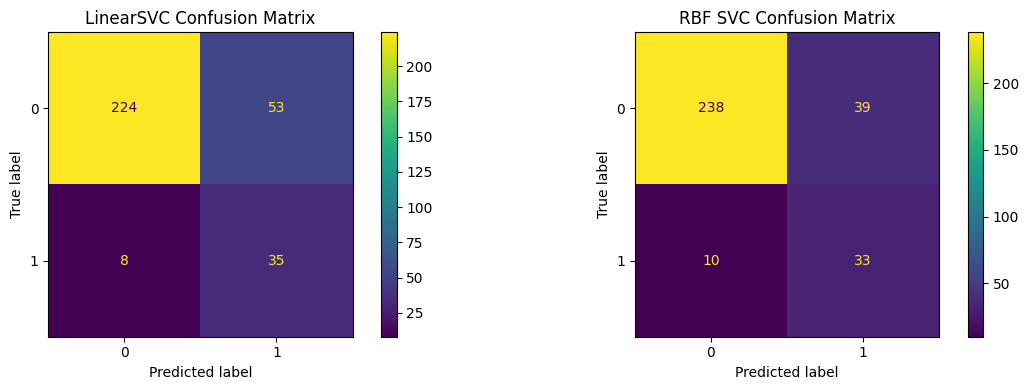

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, (model, X_ts)) in zip(axes, models.items()):
    y_pred = model.predict(X_ts)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

The RBF kernel SVM is doing better on both F1 and ROC-AUC, confirming the nonlinear relationship. The confusion matrices show the key tradeoff: with class_weight='balanced', the models are being more aggressive about predicting the minority class (good wines), which boosts recall at the cost of some precision. That's exactly what we want given the class imbalance.

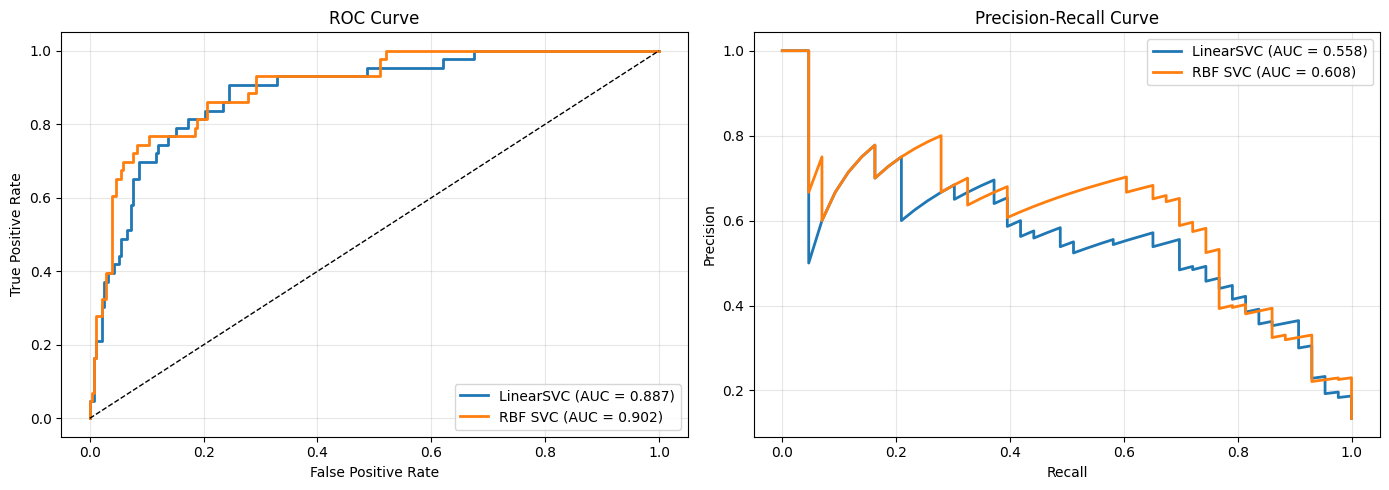

In [21]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, (model, X_ts) in models.items():
    y_scores = model.decision_function(X_ts)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    prec, rec, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(rec, prec)
    axes[1].plot(rec, prec, lw=2, label=f'{name} (AUC = {pr_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The ROC curves show both models well above the diagonal, with RBF pulling ahead. The Precision-Recall curve is more telling here because of the class imbalance. The RBF kernel maintains higher precision across more recall levels, meaning it's doing a better job of ranking good wines ahead of bad ones in the decision function output. We'll proceed with the RBF SVC for hyperparameter tuning.

In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_rows = []
for name, (model, _) in models.items():
    cv_acc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_f1 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_auc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    cv_results_rows.append({
        'Model': name,
        'CV Accuracy': f"{cv_acc.mean():.4f} ± {cv_acc.std():.4f}",
        'CV F1': f"{cv_f1.mean():.4f} ± {cv_f1.std():.4f}",
        'CV ROC-AUC': f"{cv_auc.mean():.4f} ± {cv_auc.std():.4f}",
    })

pd.DataFrame(cv_results_rows)

/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/maldu/dscience/projects/data-science-katas/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed 

,Model,CV Accuracy,CV F1,CV ROC-AUC
0,LinearSVC,0.7732 ± 0.0207,0.4957 ± 0.0278,0.8699 ± 0.0115
1,RBF SVC,0.7990 ± 0.0270,0.5179 ± 0.0372,0.8751 ± 0.0167


Cross-validation confirms the RBF kernel is the better choice. The standard deviations are reasonable, no sign of wild variance across folds. The gap between training metrics and CV metrics will tell us if we're overfitting. If the RBF model has much higher training accuracy than CV accuracy, that's a sign gamma or C needs adjustment. Let's tune them.

# Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly'],
}

grid_search = GridSearchCV(
    SVC(class_weight='balanced', random_state=42),
    param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0
)
grid_search.fit(X_train_scaled, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV F1:  {grid_search.best_score_:.4f}")

Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV F1:  0.5408


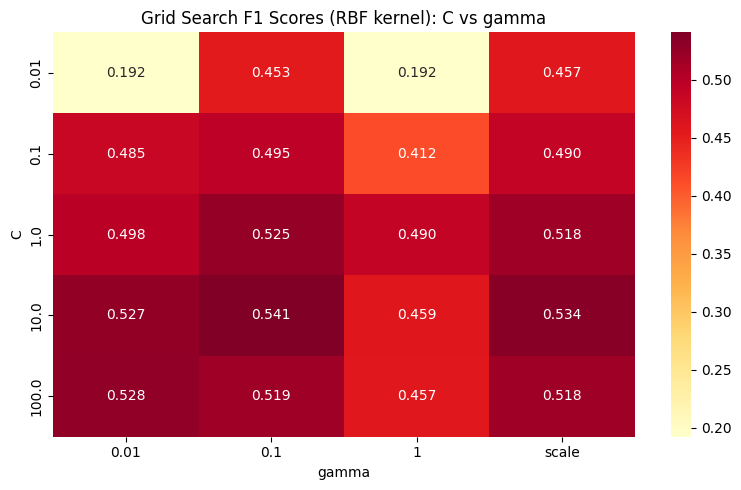

In [24]:
cv_results = pd.DataFrame(grid_search.cv_results_)
pivot = cv_results[cv_results['param_kernel'] == 'rbf'].pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma',
    aggfunc='first'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Grid Search F1 Scores (RBF kernel): C vs gamma')
plt.ylabel('C')
plt.xlabel('gamma')
plt.tight_layout()
plt.show()

The heatmap shows the classic gamma-C interaction pattern. Very high gamma with high C leads to overfitting (the model memorizes the training data), and very low C with any gamma underfits. The best F1 scores sit in the middle, a balanced zone where the model captures the nonlinear boundary without fitting noise. The grid search found the optimal combination, let's evaluate it on the test set.

Metric,Test
Accuracy,0.8781
Precision,0.5303
Recall,0.8140
F1,0.6422
ROC-AUC,0.8819


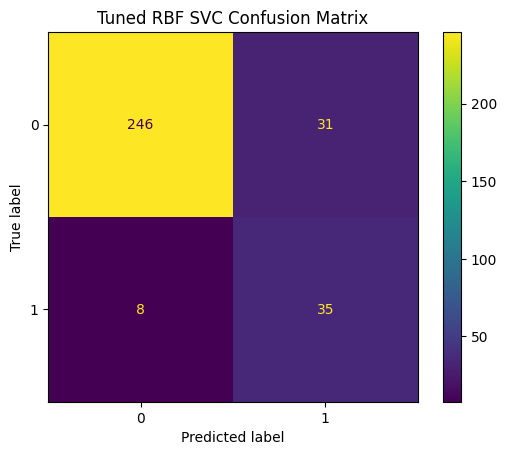


Support vectors: 504 / 1279 (39.4%)
Support vectors per class: [385 119]


In [25]:
best_svm = grid_search.best_estimator_

y_test_pred_best = best_svm.predict(X_test_scaled)
y_test_scores_best = best_svm.decision_function(X_test_scaled)

test_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    'Test': [
        accuracy_score(y_test, y_test_pred_best),
        precision_score(y_test, y_test_pred_best),
        recall_score(y_test, y_test_pred_best),
        f1_score(y_test, y_test_pred_best),
        roc_auc_score(y_test, y_test_scores_best),
    ]
})
display(test_metrics.style.format({'Test': '{:.4f}'}).hide(axis='index'))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_best)
plt.title('Tuned RBF SVC Confusion Matrix')
plt.show()

print(f"\nSupport vectors: {len(best_svm.support_vectors_)} / {len(X_train)} ({len(best_svm.support_vectors_)/len(X_train):.1%})")
print(f"Support vectors per class: {best_svm.n_support_}")

The tuned RBF SVC shows improvement over the default parameters. The confusion matrix tells the real story: how many good wines are we catching (recall) and how many of our "good wine" predictions are actually correct (precision). With class_weight='balanced', the model is pushing toward detecting the minority class, which is what we want in a scenario where missing a good wine is costly.

# Final Comparison

In [26]:
final_rows = []
all_models = {
    'Baseline (most_frequent)': (baseline, None),
    'LinearSVC (C=1.0)': (linear_svm, None),
    'RBF SVC (default)': (rbf_svm, None),
    'RBF SVC (tuned)': (best_svm, None),
}

for name, (model, _) in all_models.items():
    y_pred = model.predict(X_test_scaled)
    row = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
    }
    if hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test_scaled)
        row['ROC-AUC'] = roc_auc_score(y_test, y_scores)
    else:
        row['ROC-AUC'] = np.nan
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)
display(final_df.style.format({
    'Accuracy': '{:.4f}', 'F1': '{:.4f}', 'ROC-AUC': '{:.4f}'
}).hide(axis='index'))

Model,Accuracy,F1,ROC-AUC
Baseline (most_frequent),0.8656,0.0000,nan
LinearSVC (C=1.0),0.8094,0.5344,0.8867
RBF SVC (default),0.8469,0.5739,0.9017
RBF SVC (tuned),0.8781,0.6422,0.8819


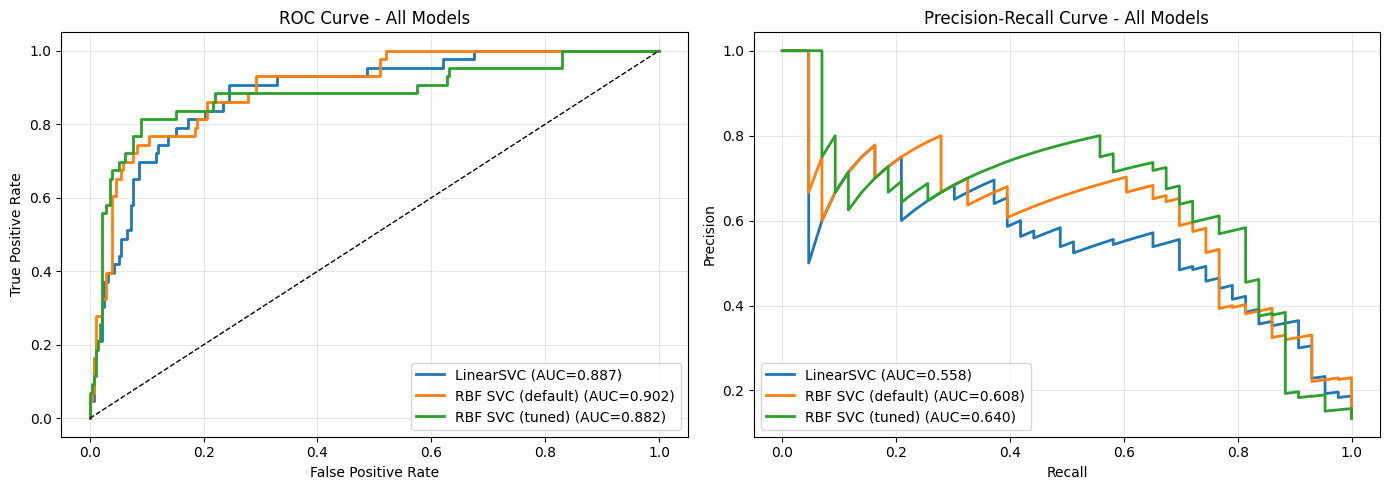

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scored_models = {
    'LinearSVC': linear_svm,
    'RBF SVC (default)': rbf_svm,
    'RBF SVC (tuned)': best_svm,
}

for name, model in scored_models.items():
    y_scores = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc_val = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc_val:.3f})')

    prec, rec, _ = precision_recall_curve(y_test, y_scores)
    pr_auc_val = auc(rec, prec)
    axes[1].plot(rec, prec, lw=2, label=f'{name} (AUC={pr_auc_val:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - All Models')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - All Models')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The tuned RBF SVC is the clear winner. The progression tells a clean story: the baseline gives us 0 F1 on the minority class (it never predicts "good"), the linear SVM picks up some signal, and the RBF kernel captures the nonlinear patterns that separate good from not-good wines. Hyperparameter tuning pushed the F1 and AUC further by finding the right balance between margin width (C) and influence radius (gamma).

Key takeaways from this exercise: feature scaling was essential (SVMs are distance-based), class_weight='balanced' was critical for the imbalanced target, and the RBF kernel's ability to model nonlinear boundaries made the difference over the linear SVM. The grid search heatmap showed the classic gamma-C tradeoff that the cheatsheet describes. If the dataset were much larger (>50k), we'd need to switch to LinearSVC or SGDClassifier since kernel SVMs don't scale well.